<font size=8> Network Tests


In [1]:
#Common Python Packages
from pickle import TRUE
import pickle
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *
from lib.dynapse2_raster import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product

#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio

# Determine the user's home directory
home_directory = os.path.expanduser("~")
# Path to the Documents directory
documents_path = os.path.join(home_directory, "Documents")
# Path to the dynapse-se2-data directory within Documents
save_directory_path = os.path.join(documents_path, "dynapse-se2-data")
# Path to the data
data_type_path = os.path.join(save_directory_path, "network_heatmaps")

In [2]:
[board,profile_path,number_of_chips]=obtain_board()

<font size=8> SWEEP

In [5]:
neuron_config=neuron_configs_bio.config()
neuron_config['Input_SST']=0#.1#.1
neuron_config['PC_SST']=0#.1
neuron_config['PC_Adaptation']=True


In [7]:

neuron_config['input_type']='Regular'

#input frequencies and conneciton ratiors
sweep_range_1=np.arange(1,31,1)
sweep_range_2=np.arange(0,.7,.1)
config_var_name_1='input_frequency'
config_var_name_2='PC_PC'
sweep_name='EI_sweep_PC_PC_regular'

run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name, data_type_path, neuron_config)

Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 1 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 2 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 3 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 4 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 5 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 6 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 7 and connection ratio 0.60
Setting Latches
Setting up network
Adding connections
Simulation timed out for input frequency 8 and connection ratio 0.60
Setting Latches


In [8]:

neuron_config['input_type']='Regular'

#input frequencies and conneciton ratiors
sweep_range_1=np.arange(1,31,1)
sweep_range_2=np.arange(0,.7,.1)
config_var_name_1='input_frequency'
config_var_name_2='PC_PV'
sweep_name='EI_sweep_PC_PV_regular'

run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name, data_type_path, neuron_config)

In [10]:
def run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name, save_name, data_type_path, neuron_config):

    data=os.path.join(data_type_path, f"{sweep_name}.npy")

    if os.path.exists(data):
        simulation_data = np.load(data, allow_pickle=True).item()
    else:
        simulation_data = {
            "cv_values_pc": [np.nan] * len(sweep_range_1) * len(sweep_range_2),
            "cv_values_pv": [np.nan] * len(sweep_range_1) * len(sweep_range_2),
            "synchrony_values_pc": [np.nan] * len(sweep_range_1) * len(sweep_range_2),
            "synchrony_values_pv": [np.nan] * len(sweep_range_1) * len(sweep_range_2),
            "mean_pc_rates": [np.nan] * len(sweep_range_1) * len(sweep_range_2),
            config_var_name_1: sweep_range_1,
            config_var_name_2: sweep_range_2
        }
    for value_1 in simulation_data[config_var_name_1]:
        neuron_config[config_var_name_1] = value_1
        for value_2 in simulation_data[config_var_name_2]:
            if contains_nan(simulation_data,config_var_name_1,config_var_name_2,value_1, value_2):
                neuron_config[config_var_name_2] = value_2
                try:
                    [output_events, test_config] = run_simulation(neuron_config)

                    cv_temp, synchrony_temp = run_dynamic_anal(output_events, test_config)

                    rates = spike_count(output_events=output_events)
                    PC_rates, _, _ = pop_rates(rates, test_config)

                    index = len(simulation_data[config_var_name_2]) * list(simulation_data[config_var_name_1]).index(value_1) + list(simulation_data[config_var_name_2]).index(value_2)
                    simulation_data["cv_values_pc"][index] = cv_temp[0]
                    simulation_data["cv_values_pv"][index] = cv_temp[1]
                    simulation_data["synchrony_values_pc"][index] = synchrony_temp[0]
                    simulation_data["synchrony_values_pv"][index] = synchrony_temp[1]
                    simulation_data["mean_pc_rates"][index] = np.mean(PC_rates)
                except timeout_decorator.TimeoutError:
                    print(f"Simulation timed out for {config_var_name_1} {value_1} and {config_var_name_2} {value_2}")
                    index = len(simulation_data[config_var_name_2]) * list(simulation_data[config_var_name_1]).index(value_1) + list(simulation_data[config_var_name_2]).index(value_2)
                    simulation_data["cv_values_pc"][index] = np.nan
                    simulation_data["cv_values_pv"][index] = np.nan
                    simulation_data["synchrony_values_pc"][index] = np.nan
                    simulation_data["synchrony_values_pv"][index] = np.nan
                    simulation_data["mean_pc_rates"][index] = np.nan

    if not os.path.exists(data_type_path):
        os.makedirs(data_type_path)
    np.save(os.path.join(data_type_path, f"{save_name}.npy"), simulation_data)


@timeout_decorator.timeout(40)# Set a 5-second timeout
def run_simulation(neuron_config):
    return pc_pv_sst.pc_pv_sst(
        board=board,
        profile_path=profile_path,
        number_of_chips=number_of_chips,
        neuron_config=neuron_config
    )

In [11]:

neuron_config['input_type']='Poisson'

#input frequencies and conneciton ratiors
sweep_range_1=np.arange(1,31,1)
sweep_range_2=np.arange(0,.7,.1)
config_var_name_1='input_frequency'
config_var_name_2='PC_PC'
sweep_name='EI_sweep_PC_PC_poisson'

run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name,sweep_name, data_type_path, neuron_config)

Setting Latches
Setting up network
Adding connections

Setting monitors
20 100 10

All configurations done!

Input events created
initilize run dynapse
dummy events sent

getting fpga time


setting virtual neurons

Simulation done
PC_CV_average: 0.31 PV_CV_average: 1.08 SST_CV_average: 0.0
PC_synchrony: 0.11 PV_CV_average: 0.21 SST_CV_average: nan
Chip 0 core 0:
[28, 17, 18, 16, 20, 22, 26, 21, 24, 16, 18, 21, 27, 27, 19, 0],
[16, 24, 17, 15, 16, 18, 15, 20, 16, 25, 18, 7, 18, 15, 19, 14],
[16, 26, 12, 17, 16, 10, 23, 19, 15, 22, 17, 16, 19, 18, 22, 13],
[20, 16, 15, 24, 24, 28, 19, 19, 22, 20, 11, 18, 17, 19, 13, 23],
[16, 11, 20, 18, 22, 19, 20, 16, 21, 15, 15, 21, 12, 14, 18, 17],
[18, 18, 23, 20, 18, 17, 21, 19, 17, 12, 16, 24, 23, 16, 24, 14],
[14, 14, 18, 16, 22, 17, 12, 19, 18, 18, 19, 18, 19, 15, 20, 9],
[13, 17, 18, 18, 0, 30, 10, 25, 29, 17, 36, 8, 32, 36, 13, 46],
[9, 58, 57, 41, 14, 45, 14, 28, 46, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0,

In [ ]:

neuron_config['input_type']='Poisson'

#input frequencies and conneciton ratiors
sweep_range_1=np.arange(1,31,1)
sweep_range_2=np.arange(0,.7,.1)
config_var_name_1='input_frequency'
config_var_name_2='PC_PV'
sweep_name='EI_sweep_PC_PV_poisson'

run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name,sweep_name, data_type_path, neuron_config)

In [ ]:

neuron_config['input_type']='Regular'

#input frequencies and conneciton ratiors
sweep_range_1=np.arange(1,31,1)
sweep_range_2=np.arange(0,.7,.1)
config_var_name_1='input_frequency'
config_var_name_2='PC_PV'
sweep_name='EI_sweep_PC_PV_regular'

run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name,sweep_name, data_type_path, neuron_config)

In [ ]:
run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name,sweep_name, data_type_path, neuron_config)

In [ ]:

neuron_config['input_type']='Regular'

#input frequencies and conneciton ratiors
sweep_range_1=np.arange(1,31,1)
sweep_range_2=np.arange(0,.7,.1)
config_var_name_1='input_frequency'
config_var_name_2='PC_PC'
sweep_name='EI_sweep_PC_PC_regular'

run_sweep(sweep_range_1, sweep_range_2, config_var_name_1, config_var_name_2, sweep_name,sweep_name, data_type_path, neuron_config)

<font size=8> Heatmaps

In [110]:
FONT_SIZE = 12
plt.rcParams['font.size'] = FONT_SIZE
import matplotlib.image

def plot_heatmap(data_matrix, ax, cmap, xlabel, ylabel, title, cbar_label,
                 x_ticks, x_ticklabels, y_ticks, y_ticklabels):
    """
    Helper function to plot a heatmap.
    """
    sns.heatmap(data_matrix[::-1], ax=ax, cmap=cmap, cbar_kws={'label': cbar_label})  # <-- Reverse the rows here
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticklabels)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticklabels[::-1])  # <-- Reverse the yticklabels here
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

def visualize_simulation_data(data, freq_range=None, title='insert_title',x_axis_label='connection_ratios'):
    """
    Load and visualize simulation data.
    """
    input_frequencies = np.arange(1,31,1)
    
    # Determine the indices of the frequencies in the range
    if freq_range:
        start, end = freq_range
        freq_indices = np.where((input_frequencies >= start) & (input_frequencies <= end))[0]
    else:
        freq_indices = np.arange(len(input_frequencies))

    # Extract the data and select only the desired range
    cv_values_pc = np.array(data['cv_values_pc']).reshape(len(input_frequencies), -1)[freq_indices]
    synchrony_values_pc = np.array(data['synchrony_values_pc']).reshape(len(input_frequencies), -1)[freq_indices]
    mean_pc_rates = np.array(data['mean_pc_rates']).reshape(len(input_frequencies), -1)[freq_indices]
    input_frequencies = input_frequencies[freq_indices]

    connection_ratios = [round(x, 1) for x in data['connection_ratios']]
    
    y_ticks = np.arange(0, len(input_frequencies), max(1, len(input_frequencies) // 5))
    y_ticklabels = [input_frequencies[i] for i in y_ticks]
    x_ticks = np.arange(len(connection_ratios)) + 0.5
    x_ticklabels = connection_ratios
    
    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    
    # Add title
    if title != 'insert_title':
        fig.suptitle(title, fontsize=16)
    plot_heatmap(cv_values_pc, ax[0], 'viridis', x_axis_label, 'Input Frequencies', 'CV Values PC', 'CV Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(synchrony_values_pc, ax[1], 'viridis', x_axis_label, 'Input Frequencies', 'Synchrony Values PC', 'Synchrony Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(mean_pc_rates, ax[2], 'viridis', x_axis_label, 'Input Frequencies', 'Mean Firing Rates PC', 'Mean Firing Rates PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    
    plt.tight_layout()
    plt.show()

    return fig,ax
# Example usage




In [ ]:
def visualize_combined_simulation_data(data1, data2, freq_range=None, title='insert_title', x_axis_label1='connection_ratios1', x_axis_label2='connection_ratios2'):
    """
    Load and visualize combined simulation data.
    """
    input_frequencies = np.arange(1,31,1)
    
    if freq_range:
        start, end = freq_range
        freq_indices = np.where((input_frequencies >= start) & (input_frequencies <= end))[0]
    else:
        freq_indices = np.arange(len(input_frequencies))

    # Add these diagnostic print statements:
    print(f"Frequency Indices: {freq_indices}")
    print(f"Length of Frequency Indices: {len(freq_indices)}")

    # For Data1
    cv_values_pc1 = np.array(data1['cv_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    synchrony_values_pc1 = np.array(data1['synchrony_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    mean_pc_rates1 = np.array(data1['mean_pc_rates']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    
    # For Data2
    cv_values_pc2 = np.array(data2['cv_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    synchrony_values_pc2 = np.array(data2['synchrony_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    mean_pc_rates2 = np.array(data2['mean_pc_rates']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    
    connection_ratios = [round(x, 1) for x in data1['connection_ratios']]
    
    y_ticks = np.arange(0, len(freq_indices), max(1, len(freq_indices) // 5))
    y_ticklabels = [input_frequencies[freq_indices[i]] for i in y_ticks]
    x_ticks = np.arange(len(connection_ratios)) + 0.5
    x_ticklabels = connection_ratios
    
    # Plotting in a 2x3 grid
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    
    # Data 1
    plot_heatmap(cv_values_pc1, ax[0,0], 'viridis', x_axis_label1, 'Input Fdef visualize_combined_simulation_data(data1, data2, freq_range=None, title='insert_title', x_axis_label1='connection_ratios1', x_axis_label2='connection_ratios2'):
    """
    Load and visualize combined simulation data.
    """
    input_frequencies = np.arange(1,31,1)
    
    if freq_range:
        start, end = freq_range
        freq_indices = np.where((input_frequencies >= start) & (input_frequencies <= end))[0]
    else:
        freq_indices = np.arange(len(input_frequencies))

    # Add these diagnostic print statements:
    print(f"Frequency Indices: {freq_indices}")
    print(f"Length of Frequency Indices: {len(freq_indices)}")

    # For Data1
    cv_values_pc1 = np.array(data1['cv_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    synchrony_values_pc1 = np.array(data1['synchrony_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    mean_pc_rates1 = np.array(data1['mean_pc_rates']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    
    # For Data2
    cv_values_pc2 = np.array(data2['cv_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    synchrony_values_pc2 = np.array(data2['synchrony_values_pc']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    mean_pc_rates2 = np.array(data2['mean_pc_rates']).reshape(len(input_frequencies), -1)[freq_indices[::-1]]
    
    connection_ratios = [round(x, 1) for x in data1['connection_ratios']]
    
    y_ticks = np.arange(0, len(freq_indices), max(1, len(freq_indices) // 5))
    y_ticklabels = [input_frequencies[freq_indices[i]] for i in y_ticks]
    x_ticks = np.arange(len(connection_ratios)) + 0.5
    x_ticklabels = connection_ratios
    
    # Plotting in a 2x3 grid
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    
    # Data 1
    plot_heatmap(cv_values_pc1, ax[0,0], 'viridis', x_axis_label1, 'Input Frequencies', 'CV Values PC1', 'CV Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(synchrony_values_pc1, ax[0,1], 'viridis', x_axis_label1, 'Input Frequencies', 'Synchrony Values PC1', 'Synchrony Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(mean_pc_rates1, ax[0,2], 'viridis', x_axis_label1, 'Input Frequencies', 'Mean Firing Rates PC1', 'Mean Firing Rates PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    
    # Data 2
    plot_heatmap(cv_values_pc2, ax[1,0], 'viridis', x_axis_label2, 'Input Frequencies', 'CV Values PC2', 'CV Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(synchrony_values_pc2, ax[1,1], 'viridis', x_axis_label2, 'Input Frequencies', 'Synchrony Values PC2', 'Synchrony Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(mean_pc_rates2, ax[1,2], 'viridis', x_axis_label2, 'Input Frequencies', 'Mean Firing Rates PC2', 'Mean Firing Rates PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    
    # Add title
    if title != 'insert_title':
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

    return fig, ax

    # Data 2
    plot_heatmap(cv_values_pc2, ax[1,0], 'viridis', x_axis_label2, 'Input Frequencies', 'CV Values PC2', 'CV Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(synchrony_values_pc2, ax[1,1], 'viridis', x_axis_label2, 'Input Frequencies', 'Synchrony Values PC2', 'Synchrony Values PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    plot_heatmap(mean_pc_rates2, ax[1,2], 'viridis', x_axis_label2, 'Input Frequencies', 'Mean Firing Rates PC2', 'Mean Firing Rates PC', x_ticks, x_ticklabels, y_ticks, y_ticklabels)
    
    # Add title
    if title != 'insert_title':
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()

    return fig, ax


<font size=6> Regular Input

In [176]:
data_path = os.path.join(data_type_path, "EI_sweep_regular.npy")
data_1 = np.load(data_path, allow_pickle=True).item()

In [177]:
data_path = os.path.join(data_type_path, "EE_sweep_regular.npy")
data_2 = np.load(data_path, allow_pickle=True).item()


In [ ]:
print(data_1.keys())
print(data_1['cv_values_pc'][24])
print(data_1['synchrony_values_pc'][24])
print(data_1['mean_pc_rates'][24])
print(data_1['input_frequencies'][12])
print(data_1['connection_ratios'][5])

Frequency Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Length of Frequency Indices: 16


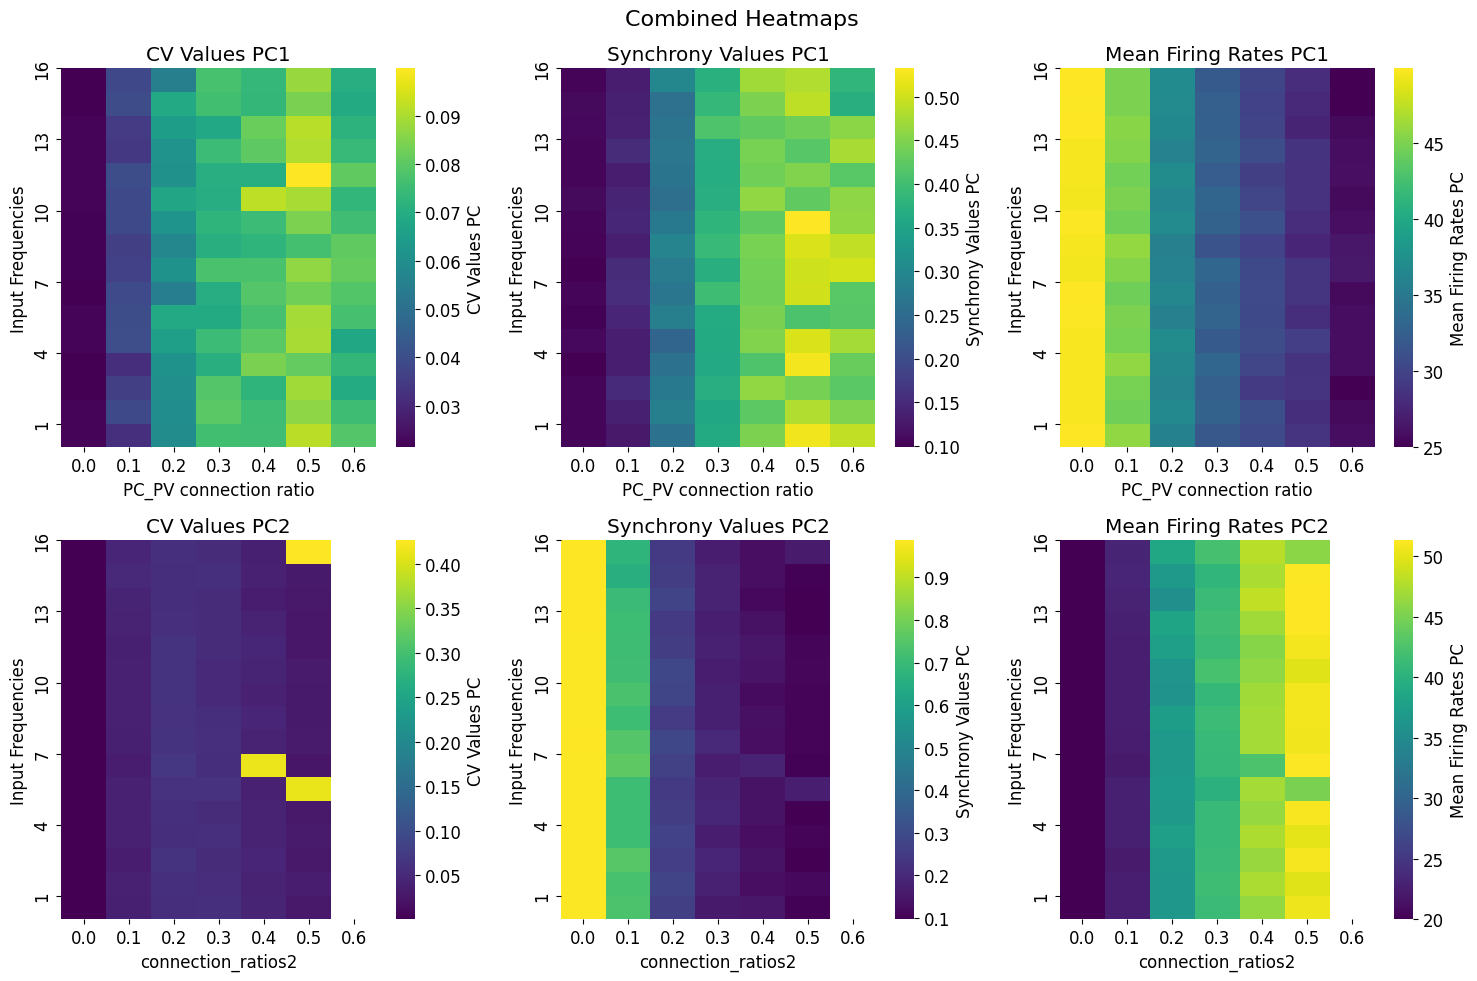

In [179]:
fig, ax = visualize_combined_simulation_data(data_1, data_2, freq_range=(0, 16), title="Combined Heatmaps", x_axis_label1='PC_PV connection ratio')


In [172]:
data_path = os.path.join(data_type_path, "EE_sweep_poisson.npy")



In [173]:
data_path = os.path.join(data_type_path, "EI_sweep_poisson.npy")
data_2 = np.load(data_path, allow_pickle=True).item()


Frequency Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Length of Frequency Indices: 20


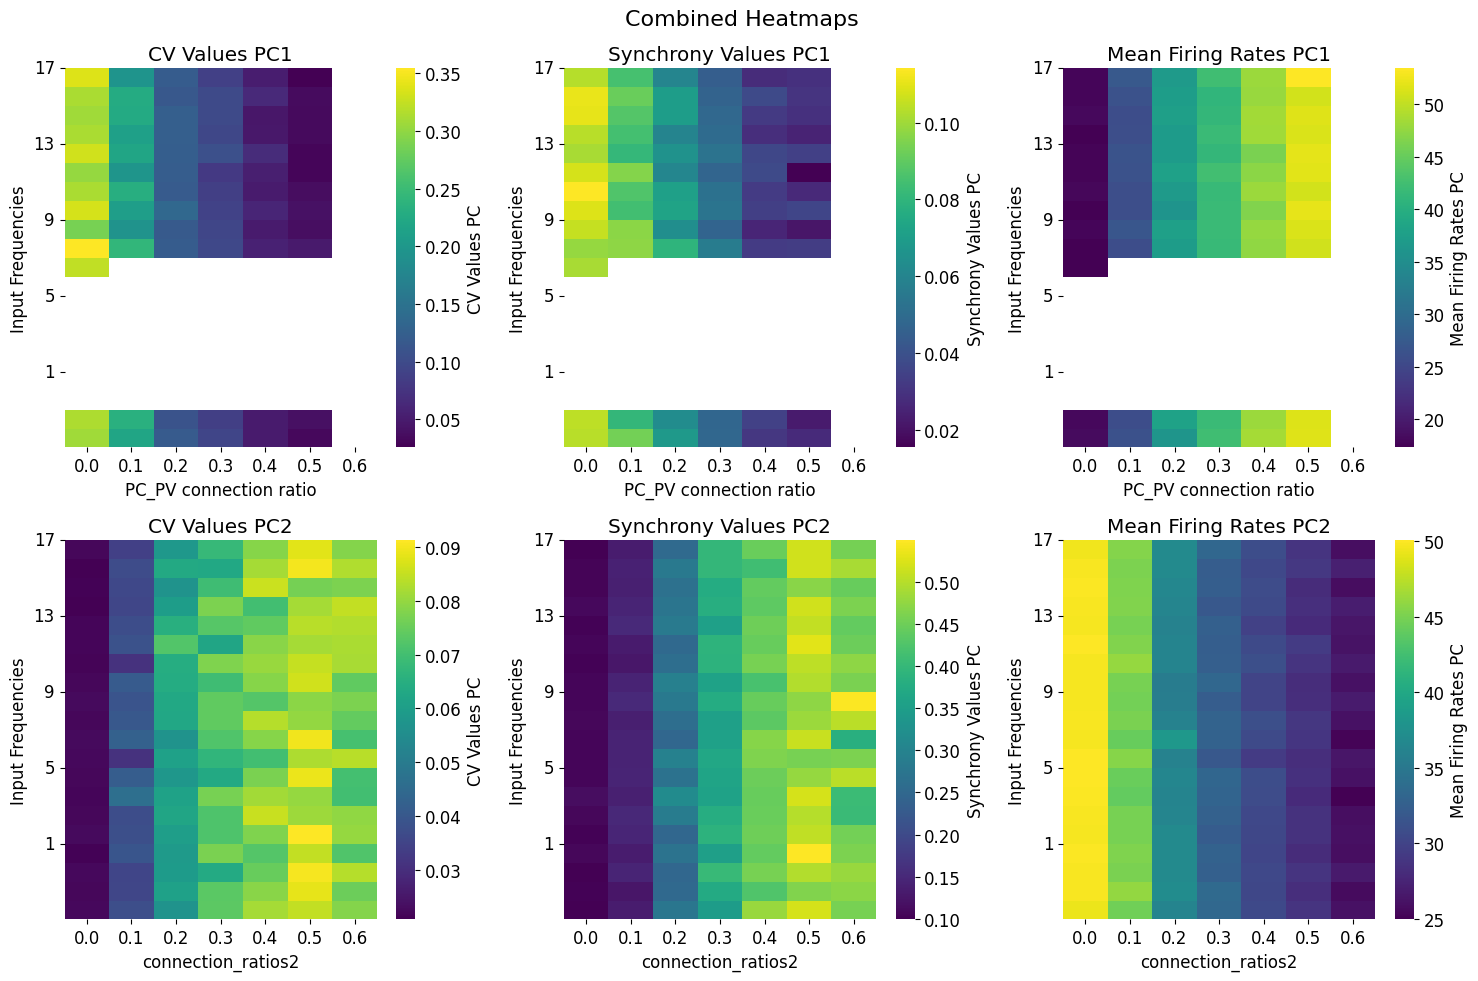

In [174]:
fig, ax = visualize_combined_simulation_data(data_1, data_2, freq_range=(0, 20), title="Combined Heatmaps", x_axis_label1='PC_PV connection ratio')
